# DATA EXTRACTION AND TRANSFORMATIONS


In [ ]:
#Connect to GDrive
from google.colab import drive
drive.mount('/content/drive')

#Load libraries
import os
import torch
from torchvision import transforms
import torch.nn as nn
import torchvision.models
from torch.nn import CrossEntropyLoss
from torch import optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from tqdm import tqdm

from PIL import Image
import numpy as np
import cv2

! pip install wget
import wget

!pip install patchify
from patchify import patchify

!pip install patchify
from patchify import patchify

import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
#Remove folders and data if they exist to avoid duplicating data.
!rm -r "test_images"
!rm -r "train_images"
!rm -r "train_masks"

#Donwload dataset from Kaggle
#The URL expires every few days
url = "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/32624/2877787/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1642613676&Signature=CelZ%2F0kKR5xAEsdt1yV5JK8M0vNZs3CTwpev9glAnkDO5BCf%2F8Lxk%2FQzw4i2iN%2FtVK%2Bw2jk7KE3H5%2Fl5aeVzmn4Ias1%2FmK1ldQI2mbRRgBHbIXOh4AMmJEu8RZfhxz4rE8jvXFqDzlFNGxPwcD1O%2Bg1nymuI2wSmk5SHSVHQHv0ztx%2BXFY6lMKHmKT0zgOkR5bUwwq9vfa1pLIyyJejKkyJrz6NAW4CPkIgYKxYZnujwch5l1%2Bo2IzU0eNIJwDkgcejyBTfjOzy2OGakt17ZfgrVNeyJJWShHlAhl3UI986KHCR4xVLJy%2BZXpGktCDTyaXvMZfHdIS2YohuVPQRq%2Fg%3D%3D&response-content-disposition=attachment%3B+filename%3Dfdl21-fdl-dsba.zip"
wget.download(url, './data.zip')

#Unzip the downloaded folder and remove the zip file.
! unzip "data.zip"
! rm "data.zip"

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=33650382f428ce6192e65b6bbf544e4353fe9e7f9487c5847bddbc8d8d99160a
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
rm: cannot remove 'test_images': No such file or directory
rm: cannot remove 'train_images': No such file or directory
rm: cannot remove 'train_masks': No such file or directory
Archive:  data.zip
  inflating: prepare_submission.py   
  inflating: test_images/test_images/10170.jpg  
  inflating: test_images/test_images/10171.jpg  
  inflating: test_images/test_images/10184.jpg  
  inflating: test_images/test_images/10566.jpg  
  inflating: test_images/test_images/10808.jpg  
  inflating: test_images/test_images/10812.jpg  
  inflating: test_images/test_images/6413.jpg  
  inflating: test_images/test_images/6424.jpg  
  inflating: test_images/test_images/6427.jpg  
  inflating: test_images/test_images/6450.jpg  
  inf

In [ ]:
#Define sizes for images and patches
img_size= 1024, 1024
mask_size = 1024, 1024
img_patch_size = 512
mask_patch_size = 512

#Image transformations, adapted to the transformations originally used to train ResNet
transform_img = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

#Transformations for training masks
transform_mask = transforms.Compose([transforms.ToTensor()])

#Define directories
directory_names = ['train_masks/train_masks','train_images/train_images']
dataset = []

#Number of classes
n_classes = 25

#Iterate through every directory
for name in directory_names:
  directory = os.fsencode(name)
  list_tensors = []
  #Iterate every file 
  for file in sorted(os.listdir(directory)):
    filename = os.fsdecode(file)
    #Pre-processing for training masks
    if name == 'train_masks/train_masks':
      #Load image
      im = cv2.imread(name + '/' + filename, cv2.IMREAD_GRAYSCALE)
      #Convert to np array
      im = np.array(im, dtype='i')
      #Resize for patchifying
      im = cv2.resize(im, dsize= mask_size,interpolation = cv2.INTER_NEAREST)
      #Separately store original image at smaller size for later use
      im_og = cv2.resize(im, dsize= (mask_patch_size,mask_patch_size),interpolation = cv2.INTER_NEAREST)
      #Patchify image and store patches in list
      patches_img = patchify(im, (mask_patch_size, mask_patch_size), step=mask_patch_size)
    #Pre-processing for images
    else:
      #Load image
      im = cv2.imread(name + '/' + filename)
      #Convert to np array
      im = np.array(im)
      #Resize for patchifying
      im = cv2.resize(im, dsize= img_size,interpolation = cv2.INTER_NEAREST)
      #Separately store original image at smaller size for later use
      im_og = cv2.resize(im, dsize= (img_patch_size,img_patch_size),interpolation = cv2.INTER_NEAREST)
      #Patchify image and store patches in list
      patches_img = patchify(im, (img_patch_size, img_patch_size, 3), step=img_patch_size)
    #Remove dimension        
    patches_img = patches_img.squeeze()
    #Iterate through all patches
    for i in range(2):
      for j in range(2):
        #Define patch
        im = patches_img[i,j,:,:]
        #Apply transformations to generate several versions of patch (flipping & rotations)
        im_list = [im, np.flip(im,axis=0).copy(), np.rot90(im, k=1, axes=(0, 1)).copy(), np.rot90(im, k=3, axes=(0, 1)).copy()]
        #Iterate through different versions
        for im in im_list:
          #Apply mask transformations
          if name == 'train_masks/train_masks':
            tensor_img = transform_mask(im)
            tensor_img = tensor_img.squeeze()
          #Apply image transformations
          else:
            tensor_img = transform_img(im)
          #Append tensor to list
          list_tensors.append(tensor_img)
    #Apply transformations to generate several versions of original image (flipping & rotations)
    im_list = [im_og, np.flip(im_og,axis=0).copy(),np.rot90(im_og, k=1, axes=(0, 1)).copy(),np.rot90(im_og, k=3, axes=(0, 1)).copy()]
    #Iterate through different versions
    for im in im_list:
      #Apply mask transformations
      if name == 'train_masks/train_masks':
        tensor_img = transform_mask(im)
        tensor_img = tensor_img.squeeze()
      #Apply image transformations
      else:
        tensor_img = transform_img(im)
      #Append tensor to list
      list_tensors.append(tensor_img)
  #Append list of tensors as element in dataset
  dataset.append(list_tensors)

In [ ]:
#Load training masks from dataset
train_masks = dataset[0]
#Load training images from dataset
train_images = dataset[1]

train_batch = []

#Append image + mask paris to list
for i in range(len(train_images)):
  pair = []
  pair.append(train_images[i])
  pair.append(train_masks[i])
  train_batch.append(pair)

In [ ]:
print(len(train_images))
print(len(train_masks))

5220
5220


#-------------------------------------------------------------------------------------------------------------------------

In [ ]:
#Define train/validation split
validation_split = 0.2
shuffle_dataset = 1
random_seed = 5

# Compute the size of the dataset and the indexes
dataset_size = len(train_batch)
indices = list(range(dataset_size))

#Get the number of validation files based on the split and the dataset size
split = int(np.floor(validation_split * dataset_size))

#Train_indices and val_indices
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

#Define batch size
bs = 3

#Define train and validation dataloaders based on the random sampling
train_dataloader = DataLoader(train_batch, batch_size=bs,sampler=train_sampler,num_workers=2, pin_memory=True)
val_dataloader = DataLoader(train_batch, batch_size=bs, sampler=valid_sampler,num_workers=2, pin_memory=True) 

In [ ]:
#UNet architecture with pre-trained ResNet18 Encoder
#Based on https://github.com/usuyama/pytorch-unet

def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

In [ ]:
#Define model
model = ResNetUNet(n_classes)

#Define loss criterion
criterion = CrossEntropyLoss()

#Specify number of epochs
epochs = 20

#Check hardware and enable CUDA if preferred, otherwise uses CPU.
enable_cuda = True

if torch.cuda.is_available() & enable_cuda:
    model = model.cuda()
    criterion = CrossEntropyLoss().cuda()
    device = torch.device("cuda")
    print("CUDA enabled, using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

#Define optimizer (should be defined after CUDA is activated)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#Define save location for model progress etc.
save_folder="/content/drive/MyDrive/Courses/FDL/Kaggle/"

#Function for saving accuracy and loss
def write_results(save_folder, epoch, train_loss, val_loss):
    ff=open('./{}/progress.txt'.format("./"),'a')
    ff.write(' E: ')
    ff.write(str(epoch))
    ff.write('         ')
    ff.write(' TRAIN_LOSS: ')
    ff.write(str('%.3f' % train_loss))
    ff.write(' VAL_LOSS: ')
    ff.write(str('%.3f' % val_loss))
    ff.write('\n')

CUDA enabled, using GPU


  0%|          | 1/1392 [00:00<16:18,  1.42it/s]

Train (epoch 1/20) [0/1392 (0%)]	Loss: 3.267107


 36%|███▌      | 501/1392 [01:57<03:27,  4.29it/s]

Train (epoch 1/20) [500/1392 (36%)]	Loss: 1.215382


 72%|███████▏  | 1001/1392 [03:53<01:30,  4.30it/s]

Train (epoch 1/20) [1000/1392 (72%)]	Loss: 0.920930


100%|██████████| 348/348 [00:23<00:00, 15.04it/s]


TRAIN_LOSS:  1.176
VAL_LOSS:  0.813


  0%|          | 1/1392 [00:00<15:49,  1.47it/s]

Train (epoch 2/20) [0/1392 (0%)]	Loss: 0.472425


 36%|███▌      | 501/1392 [01:57<03:27,  4.29it/s]

Train (epoch 2/20) [500/1392 (36%)]	Loss: 0.623961


 72%|███████▏  | 1001/1392 [03:53<01:31,  4.29it/s]

Train (epoch 2/20) [1000/1392 (72%)]	Loss: 1.120025


100%|██████████| 348/348 [00:23<00:00, 15.05it/s]


TRAIN_LOSS:  0.778
VAL_LOSS:  0.676


  0%|          | 1/1392 [00:00<15:57,  1.45it/s]

Train (epoch 3/20) [0/1392 (0%)]	Loss: 0.998669


 36%|███▌      | 501/1392 [01:57<03:28,  4.28it/s]

Train (epoch 3/20) [500/1392 (36%)]	Loss: 0.609172


 72%|███████▏  | 1001/1392 [03:53<01:30,  4.30it/s]

Train (epoch 3/20) [1000/1392 (72%)]	Loss: 0.616108


100%|██████████| 348/348 [00:23<00:00, 15.06it/s]


TRAIN_LOSS:  0.684
VAL_LOSS:  0.665


  0%|          | 1/1392 [00:00<15:23,  1.51it/s]

Train (epoch 4/20) [0/1392 (0%)]	Loss: 0.714171


 36%|███▌      | 501/1392 [01:57<03:28,  4.28it/s]

Train (epoch 4/20) [500/1392 (36%)]	Loss: 0.704467


 72%|███████▏  | 1001/1392 [03:53<01:31,  4.29it/s]

Train (epoch 4/20) [1000/1392 (72%)]	Loss: 0.650305


100%|██████████| 348/348 [00:23<00:00, 15.05it/s]


TRAIN_LOSS:  0.618
VAL_LOSS:  0.609


  0%|          | 1/1392 [00:00<20:32,  1.13it/s]

Train (epoch 5/20) [0/1392 (0%)]	Loss: 0.319153


 36%|███▌      | 501/1392 [01:57<03:26,  4.30it/s]

Train (epoch 5/20) [500/1392 (36%)]	Loss: 0.600734


 72%|███████▏  | 1001/1392 [03:53<01:30,  4.30it/s]

Train (epoch 5/20) [1000/1392 (72%)]	Loss: 0.641486


100%|██████████| 348/348 [00:23<00:00, 15.04it/s]


TRAIN_LOSS:  0.572
VAL_LOSS:  0.593


  0%|          | 1/1392 [00:00<15:45,  1.47it/s]

Train (epoch 6/20) [0/1392 (0%)]	Loss: 0.297602


 36%|███▌      | 501/1392 [01:57<03:27,  4.30it/s]

Train (epoch 6/20) [500/1392 (36%)]	Loss: 0.955366


 72%|███████▏  | 1001/1392 [03:53<01:31,  4.29it/s]

Train (epoch 6/20) [1000/1392 (72%)]	Loss: 0.432088


100%|██████████| 348/348 [00:23<00:00, 15.05it/s]


TRAIN_LOSS:  0.526
VAL_LOSS:  0.576


  0%|          | 1/1392 [00:00<15:23,  1.51it/s]

Train (epoch 7/20) [0/1392 (0%)]	Loss: 0.472315


 36%|███▌      | 501/1392 [01:57<03:27,  4.29it/s]

Train (epoch 7/20) [500/1392 (36%)]	Loss: 0.386403


 72%|███████▏  | 1001/1392 [03:53<01:30,  4.30it/s]

Train (epoch 7/20) [1000/1392 (72%)]	Loss: 0.348699


100%|██████████| 348/348 [00:23<00:00, 15.04it/s]


TRAIN_LOSS:  0.482
VAL_LOSS:  0.587


  0%|          | 1/1392 [00:00<16:01,  1.45it/s]

Train (epoch 8/20) [0/1392 (0%)]	Loss: 0.478942


 36%|███▌      | 501/1392 [01:57<03:27,  4.30it/s]

Train (epoch 8/20) [500/1392 (36%)]	Loss: 0.433499


 72%|███████▏  | 1001/1392 [03:53<01:31,  4.29it/s]

Train (epoch 8/20) [1000/1392 (72%)]	Loss: 0.278404


100%|██████████| 348/348 [00:23<00:00, 15.04it/s]


TRAIN_LOSS:  0.449
VAL_LOSS:  0.564


  0%|          | 1/1392 [00:00<16:07,  1.44it/s]

Train (epoch 9/20) [0/1392 (0%)]	Loss: 0.524003


 36%|███▌      | 501/1392 [01:57<03:27,  4.30it/s]

Train (epoch 9/20) [500/1392 (36%)]	Loss: 0.508701


 72%|███████▏  | 1001/1392 [03:53<01:30,  4.30it/s]

Train (epoch 9/20) [1000/1392 (72%)]	Loss: 0.499723


100%|██████████| 348/348 [00:23<00:00, 15.05it/s]


TRAIN_LOSS:  0.415
VAL_LOSS:  0.558


  0%|          | 1/1392 [00:00<15:49,  1.47it/s]

Train (epoch 10/20) [0/1392 (0%)]	Loss: 0.337704


 36%|███▌      | 501/1392 [01:57<03:27,  4.30it/s]

Train (epoch 10/20) [500/1392 (36%)]	Loss: 0.401391


 72%|███████▏  | 1001/1392 [03:53<01:30,  4.30it/s]

Train (epoch 10/20) [1000/1392 (72%)]	Loss: 0.405620


100%|██████████| 348/348 [00:23<00:00, 15.06it/s]


TRAIN_LOSS:  0.393
VAL_LOSS:  0.601


  0%|          | 1/1392 [00:00<15:47,  1.47it/s]

Train (epoch 11/20) [0/1392 (0%)]	Loss: 0.410955


 36%|███▌      | 501/1392 [01:57<03:27,  4.29it/s]

Train (epoch 11/20) [500/1392 (36%)]	Loss: 0.276168


 72%|███████▏  | 1001/1392 [03:53<01:30,  4.30it/s]

Train (epoch 11/20) [1000/1392 (72%)]	Loss: 0.460418


100%|██████████| 348/348 [00:23<00:00, 15.04it/s]


TRAIN_LOSS:  0.364
VAL_LOSS:  0.546


  0%|          | 1/1392 [00:00<15:44,  1.47it/s]

Train (epoch 12/20) [0/1392 (0%)]	Loss: 0.357615


 36%|███▌      | 501/1392 [01:57<03:27,  4.30it/s]

Train (epoch 12/20) [500/1392 (36%)]	Loss: 0.248921


 72%|███████▏  | 1001/1392 [03:53<01:31,  4.29it/s]

Train (epoch 12/20) [1000/1392 (72%)]	Loss: 0.404236


100%|██████████| 348/348 [00:23<00:00, 15.01it/s]


TRAIN_LOSS:  0.337
VAL_LOSS:  0.560


  0%|          | 1/1392 [00:00<15:37,  1.48it/s]

Train (epoch 13/20) [0/1392 (0%)]	Loss: 0.225134


 36%|███▌      | 501/1392 [01:57<03:27,  4.29it/s]

Train (epoch 13/20) [500/1392 (36%)]	Loss: 0.302468


 72%|███████▏  | 1001/1392 [03:53<01:30,  4.30it/s]

Train (epoch 13/20) [1000/1392 (72%)]	Loss: 0.369000


100%|██████████| 348/348 [00:23<00:00, 15.03it/s]


TRAIN_LOSS:  0.312
VAL_LOSS:  0.543


  0%|          | 1/1392 [00:00<15:57,  1.45it/s]

Train (epoch 14/20) [0/1392 (0%)]	Loss: 0.246981


 36%|███▌      | 501/1392 [01:57<03:27,  4.30it/s]

Train (epoch 14/20) [500/1392 (36%)]	Loss: 0.193922


 72%|███████▏  | 1001/1392 [03:53<01:31,  4.29it/s]

Train (epoch 14/20) [1000/1392 (72%)]	Loss: 0.125080


100%|██████████| 348/348 [00:23<00:00, 15.05it/s]


TRAIN_LOSS:  0.297
VAL_LOSS:  0.574


  0%|          | 1/1392 [00:00<15:37,  1.48it/s]

Train (epoch 15/20) [0/1392 (0%)]	Loss: 0.264895


 36%|███▌      | 501/1392 [01:57<03:28,  4.28it/s]

Train (epoch 15/20) [500/1392 (36%)]	Loss: 0.307513


 72%|███████▏  | 1001/1392 [03:53<01:31,  4.29it/s]

Train (epoch 15/20) [1000/1392 (72%)]	Loss: 0.211518


100%|██████████| 348/348 [00:23<00:00, 15.07it/s]


TRAIN_LOSS:  0.282
VAL_LOSS:  0.599


  0%|          | 1/1392 [00:00<15:05,  1.54it/s]

Train (epoch 16/20) [0/1392 (0%)]	Loss: 0.289961


 36%|███▌      | 501/1392 [01:57<03:27,  4.29it/s]

Train (epoch 16/20) [500/1392 (36%)]	Loss: 0.239569


 72%|███████▏  | 1001/1392 [03:53<01:31,  4.29it/s]

Train (epoch 16/20) [1000/1392 (72%)]	Loss: 0.362066


100%|██████████| 348/348 [00:23<00:00, 15.06it/s]


TRAIN_LOSS:  0.274
VAL_LOSS:  0.588


  0%|          | 1/1392 [00:00<15:49,  1.46it/s]

Train (epoch 17/20) [0/1392 (0%)]	Loss: 0.380702


 36%|███▌      | 501/1392 [01:57<03:27,  4.29it/s]

Train (epoch 17/20) [500/1392 (36%)]	Loss: 0.173365


 72%|███████▏  | 1001/1392 [03:53<01:30,  4.30it/s]

Train (epoch 17/20) [1000/1392 (72%)]	Loss: 0.301360


100%|██████████| 348/348 [00:23<00:00, 15.07it/s]


TRAIN_LOSS:  0.253
VAL_LOSS:  0.610


  0%|          | 1/1392 [00:00<15:40,  1.48it/s]

Train (epoch 18/20) [0/1392 (0%)]	Loss: 0.178324


 36%|███▌      | 501/1392 [01:57<03:27,  4.30it/s]

Train (epoch 18/20) [500/1392 (36%)]	Loss: 0.336639


 72%|███████▏  | 1001/1392 [03:53<01:30,  4.31it/s]

Train (epoch 18/20) [1000/1392 (72%)]	Loss: 0.409401


100%|██████████| 348/348 [00:23<00:00, 15.10it/s]


TRAIN_LOSS:  0.262
VAL_LOSS:  0.611


  0%|          | 1/1392 [00:00<15:18,  1.51it/s]

Train (epoch 19/20) [0/1392 (0%)]	Loss: 0.329704


 36%|███▌      | 501/1392 [01:57<03:27,  4.30it/s]

Train (epoch 19/20) [500/1392 (36%)]	Loss: 0.235351


 72%|███████▏  | 1001/1392 [03:53<01:31,  4.30it/s]

Train (epoch 19/20) [1000/1392 (72%)]	Loss: 0.221041


100%|██████████| 348/348 [00:23<00:00, 15.04it/s]


TRAIN_LOSS:  0.237
VAL_LOSS:  0.609


  0%|          | 1/1392 [00:00<15:16,  1.52it/s]

Train (epoch 20/20) [0/1392 (0%)]	Loss: 0.192335


 36%|███▌      | 501/1392 [01:57<03:27,  4.30it/s]

Train (epoch 20/20) [500/1392 (36%)]	Loss: 0.122968


 72%|███████▏  | 1001/1392 [03:53<01:30,  4.30it/s]

Train (epoch 20/20) [1000/1392 (72%)]	Loss: 0.179595


100%|██████████| 348/348 [00:23<00:00, 15.02it/s]


TRAIN_LOSS:  0.236
VAL_LOSS:  0.648


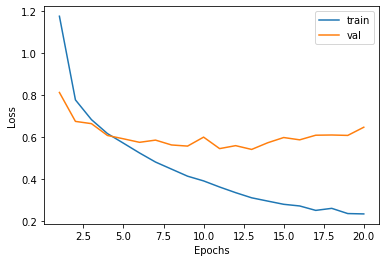

In [ ]:
total_train_losses = []
total_val_losses = []

for epoch in range(1,epochs+1):
    
    #Training
    model.train()
    train_losses = []

    #Iterate through training batches
    for i, batch, in enumerate(tqdm(train_dataloader)):
        img_batch, lbl_batch = batch

        #Transfer images and masks to GPU
        img_batch = img_batch.to(device)
        lbl_batch = lbl_batch.to(device)
        
        optimizer.zero_grad()

        #Compute output
        outputs = model(img_batch.float())

        #Compute loss
        loss=criterion(outputs, lbl_batch.long())
        
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if i % 500 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, epochs, i, len(train_dataloader),100.*i/len(train_dataloader), loss.item()))

    train_loss_mean = np.mean(train_losses)
    total_train_losses.append(train_loss_mean)

    #Validation
    model.eval()
    val_losses = []

    #Iterate through validation batches
    for i, batch, in enumerate(tqdm(val_dataloader)):
        img_batch, lbl_batch = batch

        #Transfer images and masks to GPU
        img_batch = img_batch.to(device)
        lbl_batch = lbl_batch.to(device)

        #Compute output
        outputs=model(img_batch.float())

        #Compute loss
        loss=criterion(outputs, lbl_batch.long())

        val_losses.append(loss.item())

    val_loss_mean = np.mean(val_losses)
    total_val_losses.append(val_loss_mean)

    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean)
    print('VAL_LOSS: ', '%.3f' % val_loss_mean)

    write_results(save_folder, epoch, train_loss_mean, val_loss_mean)

    #Save model
    torch.save(model.state_dict(), save_folder + 'model.pt'.format(epoch))

#Plot graph
plt.plot(list(range(epochs+1))[1:], total_train_losses)
plt.plot(list(range(epochs+1))[1:], total_val_losses)
plt.legend(['train', 'val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
#Define test image size
size= 512, 512

#Image transformations, adapted to the transformations originally used to train ResNet
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

#Define directory
directory_names = ['test_images/test_images']
dataset = []

#Iterate through every directory
for name in directory_names:
  directory = os.fsencode(name)
  list_tensors = []
  #Iterate through every file 
  for file in os.listdir(directory):
    filename = os.fsdecode(file)
    #Load image
    im = cv2.imread(name + '/' + filename)
    #Convert image to np array
    im = np.array(im)
    #Resize
    im = cv2.resize(im, dsize= size,interpolation = cv2.INTER_NEAREST)
    #Apply image transformations
    tensor_img = transform(im)
    #Append tensor to list with filename
    list_tensors.append((tensor_img,filename))

#Load test tensors into dataloder with batchsize 2
test_dataloader = DataLoader(list_tensors, batch_size=2, shuffle=True)

In [ ]:
#Delete existing predictions
!rm -r test_preds
#Create prediciton directory
!mkdir test_preds
#Define directory
dir = 'test_preds/'

#Iterate through test images 
for i, batch, in enumerate(tqdm(test_dataloader)):
  img_batch, filename = batch

  #Load test images to GPU
  img_batch = img_batch.to(device)

  #Compute output
  output = model(img_batch.float())
  
  #Transfer output from GPU and convert to numpy
  output= output.cpu().detach().numpy()

  #Iterate through batch
  for i in range(2):
    #Define image
    output2 = output[i]
    #Define filename
    filename2 = filename[i][:-4]
    mask = np.argmax(output2, axis=0)
    #Define save path
    name = dir + filename2
    #Convert array into image
    img = Image.fromarray(mask.astype(np.uint8))
    #Save mask as image
    img.save(name+'.png')

rm: cannot remove 'test_preds': No such file or directory


100%|██████████| 56/56 [00:06<00:00,  8.69it/s]


In [ ]:
#Turn masks into Kaggle format
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles():
    """Used for Kaggle submission: predicts and encode all test images"""
    dir = 'test_preds/'
    N = len(list(os.listdir(dir)))
    with open('submission_file.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in enumerate(os.listdir(dir)):
            print('{}/{}'.format(index, N))

            mask = Image.open(dir + i)
            mask = mask.resize((1024, 1024), resample=Image.NEAREST)
            mask = np.array(mask)
            print(mask)

            for x in range(1, 25):
                enc = rle_encode(mask == x)
                f.write(f"{i.split('_')[0]}_{x},{enc}\n")

create_rles()

0/112
[[ 0  0  1 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 [ 1  1  1 ... 23  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
1/112
[[ 0  0  0 ...  6  0  0]
 [ 0  0  0 ...  6  0  0]
 [ 0  0 21 ...  6  6  6]
 ...
 [ 0  0  0 ...  6  6  6]
 [ 0  0  0 ...  6  0  0]
 [ 0  0  0 ...  6  0  0]]
2/112
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 6 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
3/112
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 5 0 0]
 ...
 [0 0 6 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
4/112
[[0 0 0 ... 6 0 0]
 [0 0 0 ... 6 0 0]
 [0 0 0 ... 6 6 6]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
5/112
[[0 0 0 ... 5 0 0]
 [0 0 0 ... 5 0 0]
 [5 5 5 ... 5 5 5]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
6/112
[[ 0  0  1 ...  1  0  0]
 [ 0  0  1 ...  1  0  0]
 [ 1  1  1 ...  1  1  1]
 ...
 [23 23 23 ... 23 23 23]
 [23 23 23 ... 23 23 23]
 [23 23 23 ... 23 23 23]]
7/112
[[ 0